In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Column Reminder
# ["LOS" - Length Of Stay, "TOTCHG" - Hospital Discharge Cost, "APRDRG" - All Patient Refined Diagnosis Related Groups]
main_df = pd.read_csv("~/Desktop/kaggle_data/wisconsin_healthcare_costs/HospitalCosts.csv")
display(main_df.head())

# Goals of Project
# --- Find Age Category Who Visit the Hospital Frequently & Have Highest Costs (Age 0 By Far the Most Frequent & Length of Stay is Strongest Correlation to Cost)
#     Find The Diagnosis Related Group That Has Maximum Hospitalization and Expenditure
# --- Find if Race is Related to Cost (*** Cannot Determine; RACE 1 is Only Race with Sufficient Statistical Power ***)
#     Analyze The Severity of The Hospital Costs by Age and Gender for Proper Allocation of Resources
#     Find If The Length of Stay Can be Predicted from Age, Gender, and Race
#     Find The Variable That Mainly Affects The Hospital Costs

,AGE,FEMALE,LOS,RACE,TOTCHG,APRDRG
0,17,1,2,1.0,2660,560
1,17,0,2,1.0,1689,753
2,17,1,7,1.0,20060,930
3,17,1,1,1.0,736,758
4,17,1,1,1.0,1194,754


In [3]:
print("There are {} Diagnosis Related Groups.".format(len(main_df.APRDRG.unique())))
print("With {} Total Entries.".format(main_df.shape[0]))

There are 63 Diagnosis Related Groups.
With 500 Total Entries.


In [4]:
# Look At Mean Cost For Specific APRDRG
average_costOnAPRDRG_df = main_df.groupby(by = ['APRDRG']).TOTCHG.mean().to_frame()
average_costOnAPRDRG_df.columns = ['AVERAGE_COST']

# See the Standard Deviation for Cost of Specific APRDRG
std_costOnAPRDRG_df = main_df.groupby(by = ['APRDRG']).TOTCHG.std().to_frame()
std_costOnAPRDRG_df.columns = ['STD_COST']

# Count the Number of Cases for Specific APRDRG
count_of_cases_per_APRDRG_df = main_df.groupby(by = ['APRDRG']).TOTCHG.count().to_frame()
count_of_cases_per_APRDRG_df.columns = ['NUM_OF_CASES']

# Put All in DataFrame, Drop the NaN, Drop the Statistically Irrelavent Data
new_df = average_costOnAPRDRG_df.join(std_costOnAPRDRG_df).join(count_of_cases_per_APRDRG_df)
new_df.dropna(inplace=True)
new_df.drop(new_df[new_df.NUM_OF_CASES < 10].index, inplace=True)
display(new_df)
interesting_diagnosis_groups = new_df.index.to_list()
print("")
print("The Diagnosis Groups That Could Be Interesting.")
print(interesting_diagnosis_groups)

,AVERAGE_COST,STD_COST,NUM_OF_CASES
APRDRG,,,
53,8227.100000,2113.349971,10
640,1640.367041,754.383506,267
751,1547.571429,780.428454,14
753,2209.500000,2046.647384,36
754,1598.648649,1144.305010,37
755,859.076923,421.757525,13
758,1747.650000,908.847059,20



The Diagnosis Groups That Could Be Interesting.
[53, 640, 751, 753, 754, 755, 758]


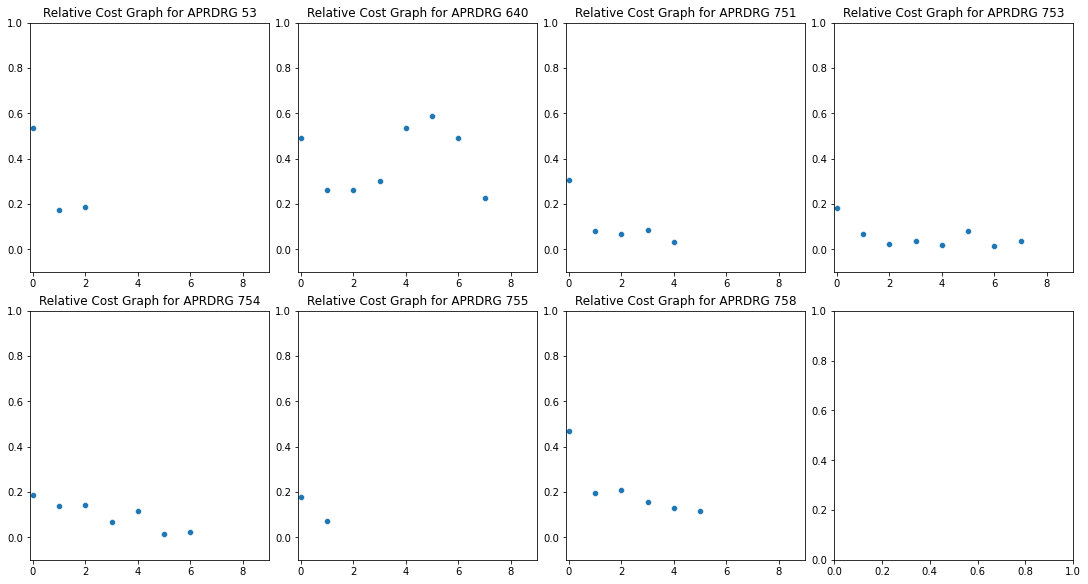

In [17]:
# Plot all of the Per Day Costs In Grid Format
pdc_fig, pdc_axes = plt.subplots(ncols=4, nrows=2, figsize=(15,8), constrained_layout=True)
nrow = 0; ncolumn = 0;
for i in interesting_diagnosis_groups:
    if ncolumn == 4:
        nrow = 1; ncolumn = 0
    tid_bit = main_df[main_df.APRDRG == i].copy()
    tid_bit['cost_per_day'] = tid_bit.TOTCHG/tid_bit.LOS
    
    tid_bit.replace([np.inf, -np.inf], np.nan, inplace=True)
    tid_bit.dropna(inplace=True)
    
    tid_bit['normalized_cost_per_day'] = (tid_bit['cost_per_day'] - tid_bit['cost_per_day'].min())/(tid_bit['cost_per_day'].max() - tid_bit['cost_per_day'].min())
    
    cost_per_day_list = tid_bit.groupby(by = ['LOS']).normalized_cost_per_day.mean().to_list()
    _ = sns.scatterplot(x=range(len(cost_per_day_list)), y=cost_per_day_list[:], ax=pdc_axes[nrow, ncolumn])
    pdc_axes[nrow, ncolumn].set_title("Relative Cost Graph for APRDRG {}".format(i))
    pdc_axes[nrow, ncolumn].set_xlim(left=-0.1, right=9)
    pdc_axes[nrow, ncolumn].set_ylim(bottom=-0.1, top=1)
    ncolumn += 1

In [44]:
# Look at Race and Cost per Day
a1 = main_df[(main_df.APRDRG == interesting_diagnosis_groups[0])].groupby(by = ['RACE']).mean().copy()
a2 = main_df[(main_df.APRDRG == interesting_diagnosis_groups[0])].groupby(by = ['RACE']).count().copy()
a1['count'] = a2.TOTCHG
# Loop Through the Rest of the APRDRG
for i in interesting_diagnosis_groups[1:]:
    b1 = main_df[(main_df.APRDRG == i)].groupby(by = ['RACE']).mean().copy()
    b2 = main_df[(main_df.APRDRG == i)].groupby(by = ['RACE']).count().copy()
    b1['count'] = b2.TOTCHG
    
    a1 = pd.concat([a1, b1])

# Look at Values that May Have Some Statistcal Value
race_breakdown_df = a1[a1['count'] > 9].copy()
display(race_breakdown_df)
# Race Comparisons Are Impossible

,AGE,FEMALE,LOS,TOTCHG,APRDRG,count
RACE,,,,,,
1.0,6.200000,0.400000,2.900000,8227.100000,53.0,10
1.0,0.000000,0.441065,2.444867,1638.288973,640.0,263
1.0,14.923077,0.923077,2.307692,1577.153846,751.0,13
1.0,14.676471,0.617647,3.000000,2213.911765,753.0,34
1.0,14.666667,0.805556,2.305556,1610.472222,754.0,36
1.0,14.000000,0.692308,1.000000,859.076923,755.0,13
1.0,15.222222,0.833333,2.611111,1707.000000,758.0,18


In [57]:
# Look to See if Age Determines Visit Issues
group_df = main_df[main_df.APRDRG == interesting_diagnosis_groups[0]].copy()
a1 = group_df.groupby(by = ['AGE']).TOTCHG.mean().to_frame().copy()
a2 = group_df.groupby(by = ['AGE']).TOTCHG.count().to_frame().copy()
a2.columns = ['count']

a1['count'] = a2['count']
a1['APRDRG'] = interesting_diagnosis_groups[0]

# Loop Through Rest and Add to Group
for i in interesting_diagnosis_groups[1:]:
    group_df = main_df[main_df.APRDRG == i].copy()
    b1 = group_df.groupby(by = ['AGE']).TOTCHG.mean().to_frame().copy()
    b2 = group_df.groupby(by = ['AGE']).TOTCHG.count().to_frame().copy()
    b2.columns = ['count']

    b1['count'] = b2['count']
    b1['APRDRG'] = i
    a1 = pd.concat([a1, b1])

display(a1[a1['count'] > 4])

,TOTCHG,count,APRDRG
AGE,,,
0,1640.367041,267,640
12,1579.800000,5,753
14,2199.600000,5,753
15,3795.333333,6,753
16,2100.800000,5,753
17,2172.800000,10,753
13,1831.875000,8,754
14,1987.285714,7,754
15,669.400000,5,754


In [93]:
# Find Statistically Relevant Length of Stay (N values)
age_df = main_df.groupby(by = ['AGE']).LOS.mean().to_frame()
age_df['LOS_std'] = main_df.groupby(by = ['AGE']).LOS.std()
age_df['count'] = main_df.groupby(by = ['AGE']).LOS.count()

display(age_df[age_df['count'] > 4])

,LOS,LOS_std,count
AGE,,,
0,3.065147,3.901859,307
1,1.800000,1.032796,10
11,1.375000,0.744024,8
12,2.400000,1.454058,15
13,2.333333,2.351470,18
14,3.040000,2.605763,25
15,3.172414,3.655416,29
16,1.827586,1.311187,29
17,2.631579,1.715132,38


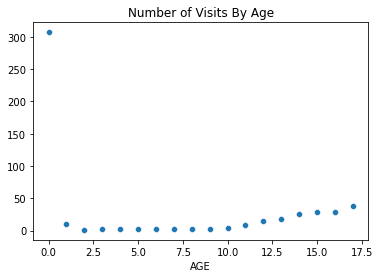

In [77]:
# Looking at Who Comes to the Hospital the Most
series = main_df.groupby(by = ['AGE']).LOS.count()
_ = sns.scatterplot(x=series.index, y=series.values).set_title('Number of Visits By Age')

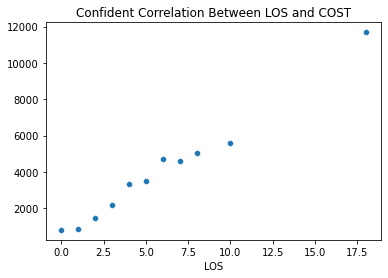

In [89]:
# Visualize the Correlation Between the the Length of Stay and Cost With Statistically Relevant Data Only
stat_good_df = main_df[main_df['APRDRG'].isin(interesting_diagnosis_groups)].groupby(by = ['LOS']).TOTCHG.mean()
_ = sns.scatterplot(x=stat_good_df.index, y=stat_good_df.values).set_title('Confident Correlation Between LOS and COST')

In [108]:
cake = main_df[main_df.APRDRG.isin(interesting_diagnosis_groups)].copy().groupby(['APRDRG']).TOTCHG.count().to_frame()
cake['mean_charge'] = main_df[main_df.APRDRG.isin(interesting_diagnosis_groups)].groupby(['APRDRG']).TOTCHG.mean()
cake['median_charge'] = main_df[main_df.APRDRG.isin(interesting_diagnosis_groups)].groupby(['APRDRG']).TOTCHG.median()
cake['std_charge'] = main_df[main_df.APRDRG.isin(interesting_diagnosis_groups)].groupby(['APRDRG']).TOTCHG.std()
display(cake)

,TOTCHG,mean_charge,median_charge,std_charge
APRDRG,,,,
53,10,8227.100000,7986.5,2113.349971
640,267,1640.367041,1408.0,754.383506
751,14,1547.571429,1350.0,780.428454
753,36,2209.500000,1590.5,2046.647384
754,37,1598.648649,1194.0,1144.305010
755,13,859.076923,763.0,421.757525
758,20,1747.650000,1410.5,908.847059


/Users/alancovell/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alancovell/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alancovell/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

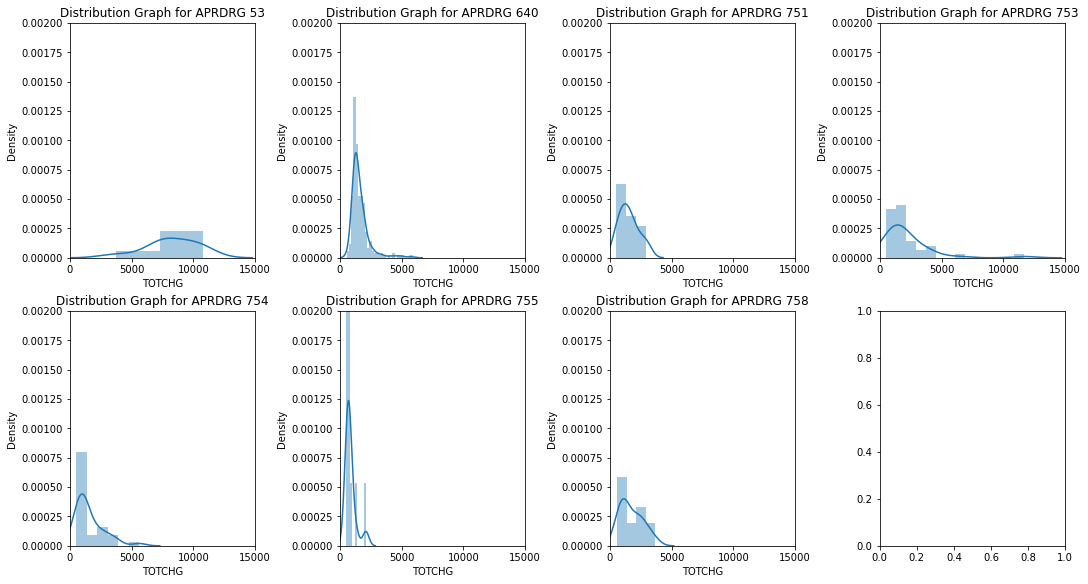

In [139]:
dist_figs, dist_ax = plt.subplots(ncols=4, nrows=2, figsize=(15,8), constrained_layout=True)
nrow = 0; ncolumn = 0;
for i in interesting_diagnosis_groups:
    if ncolumn == 4:
        nrow = 1; ncolumn = 0
    _ = sns.distplot(main_df[main_df.APRDRG == i].TOTCHG, ax=dist_ax[nrow, ncolumn])
    dist_ax[nrow, ncolumn].set_title("Distribution Graph for APRDRG {}".format(i))
    dist_ax[nrow, ncolumn].set_xlim(left=-0.1, right=15000)
    dist_ax[nrow, ncolumn].set_ylim(bottom=0, top=0.002)
    ncolumn += 1

/Users/alancovell/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


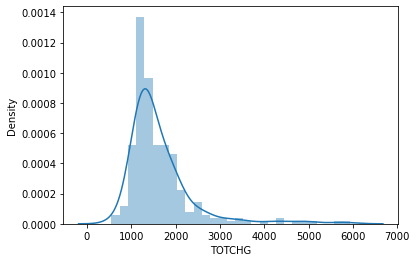

In [117]:
_ = sns.distplot(main_df[main_df.APRDRG == 640].TOTCHG)